<a href="https://colab.research.google.com/github/dhamu2908/Deep-Learning-DA6401/blob/main/Deep_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing packages
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import pandas as pd
import numpy as np
import wandb
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dhamu2908 (m_dhamu2908) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


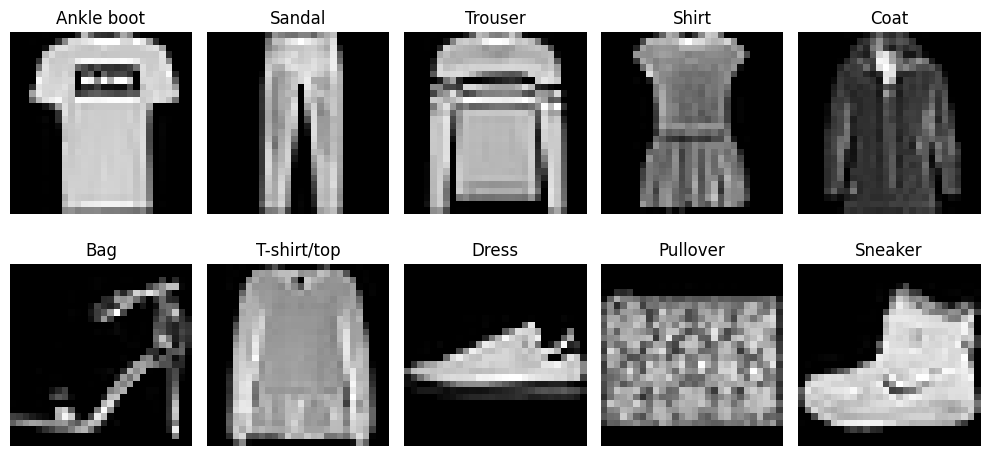

In [2]:
# Loading the Fashion MNIST dataset
(train_data, train_labels), (test_data , test_labels) = fashion_mnist.load_data()

# Defining class names
fashion_classes = ['Ankle boot', 'Sandal', 'Trouser', 'Shirt', 'Coat', 'Bag', 'T-shirt/top', 'Dress', 'Pullover', 'Sneaker']

# Function to select one image for one class
def select_images_per_class(images, labels, num_classes=10):
    selected_images = []
    for class_id in range(num_classes):
        # Find the first image that belongs to the current class
        first_image_index = np.where(labels == class_id)[0][0]
        selected_images.append(images[first_image_index])
    return selected_images

# Selecting one image for one class
selected_images = select_images_per_class(train_data, train_labels)

# Function to visualize
def visualize_and_log_images(images, class_names, save_filename='fashion_mnist_samples.png'):
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_filename)

    wandb.login()
    wandb.init(project='Deep_Learning_Assignment', name = "Fashion-Images")
    wandb.log({"Fashion MNIST Samples": wandb.Image(save_filename)})

    plt.show()

visualize_and_log_images(selected_images, fashion_classes)

In [2]:
# Function to preprocess
def preprocess_image_data(images):
    return np.array([img.flatten() / 255.0 for img in images])

# Loading the Fashion MNIST dataset
(train_data, train_labels), (test_data, y_test_data) = fashion_mnist.load_data()

# Preprocessing the training and test datasets
x_total_train_processed = preprocess_image_data(train_data)
x_test_processed = preprocess_image_data(test_data)

# Split the training data into training and validation sets randomly
train_validation_split_ratio = 0.9  # 90% training, 10% validation
x_train_final, x_validation_final, y_train_final, y_validation_final = train_test_split(
    x_total_train_processed, train_labels, train_size=train_validation_split_ratio, random_state=42
)

flattened_test_data = []


for i in range(0, len(test_data)):
    flattened_test_data.append(test_data[i].flatten()/255.0)

split_index = int(len(x_total_train_processed) * train_validation_split_ratio)

x_train_final = x_total_train_processed[:split_index]
y_train_final = train_labels[:split_index]
x_validation_final = x_total_train_processed[split_index:]
y_validation_final = train_labels[split_index:]


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
class NeuralNetwork:
    def __init__(self, input_neurons, output_neurons, config):

        self.hidden_layers = config["hidden_layers"]
        self.hidden_neurons = config["hl_size"]
        self.input_neurons = input_neurons
        self.output_neurons = output_neurons
        self.total_layers = self.hidden_layers + 1
        self.output_layer_index = self.total_layers - 1
        self.config = config
        self.input_layer_neurons = input_neurons
        self.output_layer_neurons = output_neurons

        # Initialize weights and biases
        self.weights = []
        self.biases = []

        if self.config["initialization"] == "random":
            self._initialize_random()
        elif self.config["initialization"] == "xavier":
            self._initialize_xavier()

    def _initialize_random(self):
        """Initializes weights and biases with small randomly."""
        for i in range(self.total_layers):
            if i == 0:
                layer_weights = np.random.randn(self.hidden_neurons, self.input_neurons) * 0.01
                layer_biases = np.random.randn(self.hidden_neurons, 1) * 0.01
            elif i == self.output_layer_index:
                layer_weights = np.random.randn(self.output_neurons, self.hidden_neurons) * 0.01
                layer_biases = np.random.randn(self.output_neurons, 1) * 0.01
            else:
                layer_weights = np.random.randn(self.hidden_neurons, self.hidden_neurons) * 0.01
                layer_biases = np.random.randn(self.hidden_neurons, 1) * 0.01
            self.weights.append(layer_weights)
            self.biases.append(layer_biases)

    def _initialize_xavier(self):
        """Initializes weights using Xavier initialization and biases randomly."""
        for i in range(self.total_layers):
            if i == 0:
                scale = np.sqrt(2.0 / (self.hidden_neurons + self.input_neurons))
                layer_weights = np.random.randn(self.hidden_neurons, self.input_neurons) * scale
                layer_biases = np.zeros((self.hidden_neurons, 1))
            elif i == self.output_layer_index:
                scale = np.sqrt(2.0 / (self.hidden_neurons + self.output_neurons))
                layer_weights = np.random.randn(self.output_neurons, self.hidden_neurons) * scale
                layer_biases = np.zeros((self.output_neurons, 1))
            else:
                scale = np.sqrt(2.0 / (self.hidden_neurons + self.hidden_neurons))
                layer_weights = np.random.randn(self.hidden_neurons, self.hidden_neurons) * scale
                layer_biases = np.zeros((self.hidden_neurons, 1))
            self.weights.append(layer_weights)
            self.biases.append(layer_biases)

    # Activation functions and their derivatives
    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))


    def tanh(self, x):
        return np.tanh(x)


    def tanh_derivative(self, x):
        return 1 - self.tanh(x) ** 2


    def relu(self, x):
        return np.maximum(0, x)


    def relu_derivative(self, x):
        result = np.zeros_like(x)
        for i in range(len(x)):
            if x[i] > 0:
                result[i] = 1
        return result


    def softmax(self, x):
        log_softmax = x - np.max(x)  # For Numerical stability
        log_softmax -= np.log(np.sum(np.exp(log_softmax), axis=0))
        return np.exp(log_softmax)


    def apply_activation(self, activation_name, x):
        activation_functions = {
            "sigmoid": self.sigmoid,
            "relu": self.relu,
            "tanh": self.tanh,
        }
        if activation_name in activation_functions:
            return activation_functions[activation_name](x)


    # Method to compute activation derivative
    def compute_activation_derivative(self, activation_name, x):
        if activation_name == "sigmoid":
            return self.sigmoid_derivative(x)
        elif activation_name == "relu":
            return self.relu_derivative(x)
        elif activation_name == "tanh":
            return self.tanh_derivative(x)

    # Method to perform backpropagation and compute gradients for weights and biases
    def compute_gradients(self, activations, pre_activations, true_label, input_data):
        # Initialize lists to store gradients for activations, pre-activations, weights, and biases
        grad_activations = [None] * self.total_layers
        grad_pre_activations = [None] * self.total_layers
        grad_weights = [None] * self.total_layers
        grad_biases = [None] * self.total_layers

        # Create one-hot encoded vector for the true label
        one_hot_label = np.zeros((self.output_layer_neurons, 1))
        one_hot_label[true_label] = 1

        # Compute the gradient of the loss with respect to the output layer's pre-activations
        if self.config["loss"] == "cross_entropy":
            grad_pre_activations[self.total_layers - 1] = -(one_hot_label - activations[self.total_layers - 1])
        elif self.config["loss"] == "mean_squared_error":
            output_activation = activations[self.total_layers - 1]
            grad_pre_activations[self.total_layers - 1] = (output_activation - one_hot_label) * output_activation * (1 - output_activation)

        # Iterate through layers in reverse order to compute gradients
        for layer_idx in range(self.total_layers - 1, -1, -1):
            if layer_idx == 0:
                # Compute weight gradients for the input layer
                grad_weights[layer_idx] = np.matmul(grad_pre_activations[layer_idx], input_data.reshape(1, -1))
            else:
                # Compute weight gradients for hidden and output layers
                grad_weights[layer_idx] = np.matmul(grad_pre_activations[layer_idx], activations[layer_idx - 1].T)

            # Bias gradients are the same as the pre-activation gradients
            grad_biases[layer_idx] = np.copy(grad_pre_activations[layer_idx])

            if layer_idx - 1 >= 0:
                # Compute gradients for the previous layer's activations
                grad_activations[layer_idx - 1] = np.matmul(self.weights[layer_idx].T, grad_pre_activations[layer_idx])
                # Compute gradients for the previous layer's pre-activations
                grad_pre_activations[layer_idx - 1] = grad_activations[layer_idx - 1] * self.compute_activation_derivative(self.config["activation"], pre_activations[layer_idx - 1])

        # Return the computed gradients for weights and biases
        return grad_weights, grad_biases

    # Takes a flattened image as input and returns activations and pre-activations for all layers
    def forward_propagate(self, input_data):
        # Initialize lists to store pre-activations and activations for each layer
        pre_activations = [None] * self.total_layers
        activations = [None] * self.total_layers

        # Iterate through each layer in the network
        for layer_idx in range(self.total_layers):
            if layer_idx == 0:
                # Compute pre-activation for the input layer
                pre_activations[layer_idx] = np.matmul(self.weights[layer_idx], input_data.reshape(self.input_layer_neurons, 1)) + self.biases[layer_idx]
                # Apply activation function to get the activation for the input layer
                activations[layer_idx] = self.apply_activation(self.config["activation"], pre_activations[layer_idx])

            elif layer_idx == self.total_layers - 1:
                # Compute pre-activation for the output layer
                pre_activations[layer_idx] = np.matmul(self.weights[layer_idx], activations[layer_idx - 1]) + self.biases[layer_idx]
                # Apply softmax activation for the output layer
                activations[layer_idx] = self.softmax(pre_activations[layer_idx])

            else:
                # Compute pre-activation for hidden layers
                pre_activations[layer_idx] = np.matmul(self.weights[layer_idx], activations[layer_idx - 1]) + self.biases[layer_idx]
                # Apply activation function for hidden layers
                activations[layer_idx] = self.apply_activation(self.config["activation"], pre_activations[layer_idx])

        return activations, pre_activations

    def update_parameters_with_momentum(self, weight_updates, bias_updates):
        for layer_index in range(self.total_layers):
            self.weights[layer_index] -= weight_updates[layer_index]
            self.biases[layer_index] -= bias_updates[layer_index]

    # Method to perform gradient descent with momentum optimization
    def momentum_based_gradient_descent(self, training_data, training_labels, validation_data, validation_labels):
        # Initialize previous updates for weights and biases with zeros
        previous_weight_updates = [np.zeros_like(weight) for weight in self.weights]
        previous_bias_updates = [np.zeros_like(bias) for bias in self.biases]

        # Temporary variables to store current updates
        current_weight_updates = [np.zeros_like(weight) for weight in self.weights]
        current_bias_updates = [np.zeros_like(bias) for bias in self.biases]

        # Hyperparameters
        momentum_beta = self.config["momentum_beta"]
        batch_size = self.config["batch_size"]
        learning_rate = self.config["learning_rate"]
        weight_decay = self.config["weight_decay"]

        # Training loop over epochs
        for epoch in range(self.config["epochs"]):
            # Process data in mini-batches
            for batch_start in range(0, len(training_data), batch_size):
                batch_data = training_data[batch_start:batch_start + batch_size]
                batch_labels = training_labels[batch_start:batch_start + batch_size]

                # Initialize gradients for weights and biases
                weight_gradients = [np.zeros_like(weight) for weight in self.weights]
                bias_gradients = [np.zeros_like(bias) for bias in self.biases]

                # Compute gradients for each sample in the batch
                for sample_index in range(len(batch_data)):
                    activations, pre_activations = self.forward_propagate(batch_data[sample_index])
                    sample_weight_gradients, sample_bias_gradients = self.compute_gradients(activations, pre_activations, batch_labels[sample_index], batch_data[sample_index])

                    # Accumulate gradients
                    for layer_index in range(self.total_layers):
                        weight_gradients[layer_index] += sample_weight_gradients[layer_index]
                        bias_gradients[layer_index] += sample_bias_gradients[layer_index]

                # Update weights and biases using momentum
                for layer_index in range(self.total_layers):
                    # Update weights
                    current_weight_updates[layer_index] = momentum_beta * previous_weight_updates[layer_index] + learning_rate * weight_gradients[layer_index]
                    self.weights[layer_index] -= current_weight_updates[layer_index] + weight_decay * self.weights[layer_index]
                    previous_weight_updates[layer_index] = current_weight_updates[layer_index]

                    # Update biases
                    current_bias_updates[layer_index] = momentum_beta * previous_bias_updates[layer_index] + learning_rate * bias_gradients[layer_index]
                    self.biases[layer_index] -= current_bias_updates[layer_index]
                    previous_bias_updates[layer_index] = current_bias_updates[layer_index]

            # Calculate and log loss at specific intervals
            if (self.config["epochs"] == 10 and epoch % 2 == 1) or self.config["epochs"] == 5:
                self.calculate_loss(training_data, training_labels, validation_data, validation_labels, epoch)

    # Method to perform stochastic gradient descent with mini-batches
    def stochastic_gradient_descent(self, training_data, training_labels, validation_data, validation_labels):
        # Hyperparameters
        batch_size = self.config["batch_size"]
        learning_rate = self.config["learning_rate"]
        weight_decay = self.config["weight_decay"]

        # Training loop over epochs
        for epoch in range(self.config["epochs"]):
            # Process data in mini-batches
            for batch_start in range(0, len(training_data), batch_size):
                batch_data = training_data[batch_start:batch_start + batch_size]
                batch_labels = training_labels[batch_start:batch_start + batch_size]

                # Initialize gradients for weights and biases
                weight_gradients = [np.zeros_like(weight) for weight in self.weights]
                bias_gradients = [np.zeros_like(bias) for bias in self.biases]

                # Compute gradients for each sample in the batch
                for sample_index in range(len(batch_data)):
                    # Forward pass
                    activations, pre_activations = self.forward_propagate(batch_data[sample_index])
                    # Backward pass
                    sample_weight_gradients, sample_bias_gradients = self.compute_gradients(activations, pre_activations, batch_labels[sample_index], batch_data[sample_index])

                    # Accumulate gradients
                    for layer_index in range(self.total_layers):
                        weight_gradients[layer_index] += sample_weight_gradients[layer_index]
                        bias_gradients[layer_index] += sample_bias_gradients[layer_index]

                # Update weights and biases using the computed gradients
                for layer_index in range(self.total_layers):
                    # Update weights with weight decay
                    self.weights[layer_index] -= learning_rate * weight_gradients[layer_index] + weight_decay * self.weights[layer_index]
                    # Update biases
                    self.biases[layer_index] -= learning_rate * bias_gradients[layer_index]

            # Calculate and log loss at specific intervals
            if (self.config["epochs"] == 10 and epoch % 2 == 1) or self.config["epochs"] == 5:
                self.calculate_loss(training_data, training_labels, validation_data, validation_labels, epoch)

    def nesterov_gradient_descent(self, training_data, training_labels, validation_data, validation_labels):
        # Initialize previous updates for weights and biases with zeros
        previous_weight_updates = [np.zeros_like(weight) for weight in self.weights]
        previous_bias_updates = [np.zeros_like(bias) for bias in self.biases]

        # Temporary variables to store current updates
        current_weight_updates = [np.zeros_like(weight) for weight in self.weights]
        current_bias_updates = [np.zeros_like(bias) for bias in self.biases]

        # Hyperparameters
        momentum_beta = self.config["momentum_beta"]
        batch_size = self.config["batch_size"]
        learning_rate = self.config["learning_rate"]
        weight_decay = self.config["weight_decay"]

        # Training loop over epochs
        for epoch in range(self.config["epochs"]):
            # Process data in mini-batches
            for batch_start in range(0, len(training_data), batch_size):
                batch_data = training_data[batch_start:batch_start + batch_size]
                batch_labels = training_labels[batch_start:batch_start + batch_size]

                # Initialize gradients for weights and biases
                weight_gradients = [np.zeros_like(weight) for weight in self.weights]
                bias_gradients = [np.zeros_like(bias) for bias in self.biases]

                # Compute lookahead updates for weights and biases
                for layer_index in range(self.total_layers):
                    current_weight_updates[layer_index] = momentum_beta * previous_weight_updates[layer_index]
                    current_bias_updates[layer_index] = momentum_beta * previous_bias_updates[layer_index]

                # Update parameters temporarily for lookahead gradient calculation
                self.update_parameters_with_momentum(current_weight_updates, current_bias_updates)

                # Compute gradients for each sample in the batch
                for sample_index in range(len(batch_data)):
                    # Forward pass
                    activations, pre_activations = self.forward_propagate(batch_data[sample_index])
                    # Backward pass
                    sample_weight_gradients, sample_bias_gradients = self.compute_gradients(activations, pre_activations, batch_labels[sample_index], batch_data[sample_index])

                    # Accumulate gradients
                    for layer_index in range(self.total_layers):
                        weight_gradients[layer_index] += sample_weight_gradients[layer_index]
                        bias_gradients[layer_index] += sample_bias_gradients[layer_index]

                # Update weights and biases using Nesterov Accelerated Gradient Descent
                for layer_index in range(self.total_layers):
                    # Update weights
                    previous_weight_updates[layer_index] = current_weight_updates[layer_index] + learning_rate * weight_gradients[layer_index]
                    self.weights[layer_index] -= previous_weight_updates[layer_index] + weight_decay * self.weights[layer_index]

                    # Update biases
                    previous_bias_updates[layer_index] = current_bias_updates[layer_index] + learning_rate * bias_gradients[layer_index]
                    self.biases[layer_index] -= previous_bias_updates[layer_index]

            # Calculate and log loss at specific intervals
            if (self.config["epochs"] == 10 and epoch % 2 == 1) or self.config["epochs"] == 5:
                self.calculate_loss(training_data, training_labels, validation_data, validation_labels, epoch)

    # Method to perform RMSProp optimization
    def rmsprop_optimization(self, training_data, training_labels, validation_data, validation_labels):
        # Initialize exponentially weighted averages of squared gradients for weights and biases
        squared_grad_weights = [np.zeros_like(weight) for weight in self.weights]
        squared_grad_biases = [np.zeros_like(bias) for bias in self.biases]

        # Hyperparameters
        decay_rate = self.config["rms_beta"]  # Decay rate for the moving average
        epsilon = 1e-4  # Small constant to avoid division by zero
        batch_size = self.config["batch_size"]
        learning_rate = self.config["learning_rate"]
        weight_decay = self.config["weight_decay"]

        # Training loop over epochs
        for epoch in range(self.config["epochs"]):
            # Process data in mini-batches
            for batch_start in range(0, len(training_data), batch_size):
                batch_data = training_data[batch_start:batch_start + batch_size]
                batch_labels = training_labels[batch_start:batch_start + batch_size]

                # Initialize gradients for weights and biases
                weight_gradients = [np.zeros_like(weight) for weight in self.weights]
                bias_gradients = [np.zeros_like(bias) for bias in self.biases]

                # Compute gradients for each sample in the batch
                for sample_index in range(len(batch_data)):
                    # Forward pass
                    activations, pre_activations = self.forward_propagate(batch_data[sample_index])
                    # Backward pass
                    sample_weight_gradients, sample_bias_gradients = self.compute_gradients(activations, pre_activations, batch_labels[sample_index], batch_data[sample_index])

                    # Accumulate gradients
                    for layer_index in range(self.total_layers):
                        weight_gradients[layer_index] += sample_weight_gradients[layer_index]
                        bias_gradients[layer_index] += sample_bias_gradients[layer_index]

                # Update exponentially weighted averages of squared gradients and parameters
                for layer_index in range(self.total_layers):
                    # Update squared gradients for weights
                    squared_grad_weights[layer_index] = decay_rate * squared_grad_weights[layer_index] + (1 - decay_rate) * (weight_gradients[layer_index] ** 2)
                    # Update weights with RMSProp and weight decay
                    self.weights[layer_index] -= learning_rate * weight_gradients[layer_index] / (np.sqrt(squared_grad_weights[layer_index]) + epsilon) + weight_decay * self.weights[layer_index]

                    # Update squared gradients for biases
                    squared_grad_biases[layer_index] = decay_rate * squared_grad_biases[layer_index] + (1 - decay_rate) * (bias_gradients[layer_index] ** 2)
                    # Update biases with RMSProp
                    self.biases[layer_index] -= learning_rate * bias_gradients[layer_index] / (np.sqrt(squared_grad_biases[layer_index]) + epsilon)

            # Calculate and log loss at specific intervals
            if (self.config["epochs"] == 10 and epoch % 2 == 1) or self.config["epochs"] == 5:
                self.calculate_loss(training_data, training_labels, validation_data, validation_labels, epoch)

    # Method to perform Adam optimization
    def adam_optimization(self, training_data, training_labels, validation_data, validation_labels):
        # Initialize first and second moment estimates for weights and biases
        first_moment_weights = [np.zeros_like(weight) for weight in self.weights]
        first_moment_biases = [np.zeros_like(bias) for bias in self.biases]
        second_moment_weights = [np.zeros_like(weight) for weight in self.weights]
        second_moment_biases = [np.zeros_like(bias) for bias in self.biases]

        # Initialize bias-corrected moment estimates
        first_moment_weights_hat = [np.zeros_like(weight) for weight in self.weights]
        first_moment_biases_hat = [np.zeros_like(bias) for bias in self.biases]
        second_moment_weights_hat = [np.zeros_like(weight) for weight in self.weights]
        second_moment_biases_hat = [np.zeros_like(bias) for bias in self.biases]

        # Hyperparameters
        beta1 = self.config["beta1"]  # Exponential decay rate for the first moment estimates
        beta2 = self.config["beta2"]  # Exponential decay rate for the second moment estimates
        epsilon = self.config["eps"]  # Small constant to avoid division by zero
        batch_size = self.config["batch_size"]
        learning_rate = self.config["learning_rate"]
        weight_decay = self.config["weight_decay"]

        # Training loop over epochs
        for epoch in range(self.config["epochs"]):
            # Process data in mini-batches
            for batch_start in range(0, len(training_data), batch_size):
                batch_data = training_data[batch_start:batch_start + batch_size]
                batch_labels = training_labels[batch_start:batch_start + batch_size]

                # Initialize gradients for weights and biases
                weight_gradients = [np.zeros_like(weight) for weight in self.weights]
                bias_gradients = [np.zeros_like(bias) for bias in self.biases]

                # Compute gradients for each sample in the batch
                for sample_index in range(len(batch_data)):
                    # Forward pass
                    activations, pre_activations = self.forward_propagate(batch_data[sample_index])
                    # Backward pass
                    sample_weight_gradients, sample_bias_gradients = self.compute_gradients(activations, pre_activations, batch_labels[sample_index], batch_data[sample_index])

                    # Accumulate gradients
                    for layer_index in range(self.total_layers):
                        weight_gradients[layer_index] += sample_weight_gradients[layer_index]
                        bias_gradients[layer_index] += sample_bias_gradients[layer_index]

                # Update first and second moment estimates and parameters
                for layer_index in range(self.total_layers):
                    # Update first moment estimates (mean)
                    first_moment_weights[layer_index] = beta1 * first_moment_weights[layer_index] + (1 - beta1) * weight_gradients[layer_index]
                    first_moment_biases[layer_index] = beta1 * first_moment_biases[layer_index] + (1 - beta1) * bias_gradients[layer_index]

                    # Update second moment estimates (uncentered variance)
                    second_moment_weights[layer_index] = beta2 * second_moment_weights[layer_index] + (1 - beta2) * (weight_gradients[layer_index] ** 2)
                    second_moment_biases[layer_index] = beta2 * second_moment_biases[layer_index] + (1 - beta2) * (bias_gradients[layer_index] ** 2)

                    # Compute bias-corrected moment estimates
                    first_moment_weights_hat[layer_index] = first_moment_weights[layer_index] / (1 - np.power(beta1, epoch + 1))
                    first_moment_biases_hat[layer_index] = first_moment_biases[layer_index] / (1 - np.power(beta1, epoch + 1))
                    second_moment_weights_hat[layer_index] = second_moment_weights[layer_index] / (1 - np.power(beta2, epoch + 1))
                    second_moment_biases_hat[layer_index] = second_moment_biases[layer_index] / (1 - np.power(beta2, epoch + 1))

                    # Update weights and biases using Adam optimization
                    self.weights[layer_index] -= learning_rate * first_moment_weights_hat[layer_index] / (np.sqrt(second_moment_weights_hat[layer_index]) + epsilon) + weight_decay * self.weights[layer_index]
                    self.biases[layer_index] -= learning_rate * first_moment_biases_hat[layer_index] / (np.sqrt(second_moment_biases_hat[layer_index]) + epsilon)

            # Calculate and log loss at specific intervals
            if (self.config["epochs"] == 10 and epoch % 2 == 1) or self.config["epochs"] == 5:
                self.calculate_loss(training_data, training_labels, validation_data, validation_labels, epoch)

    # Method to perform NAdam optimization
    def nadam_optimization(self, training_data, training_labels, validation_data, validation_labels):
        # Initialize first and second moment estimates for weights and biases
        first_moment_weights = [np.zeros_like(weight) for weight in self.weights]
        first_moment_biases = [np.zeros_like(bias) for bias in self.biases]
        second_moment_weights = [np.zeros_like(weight) for weight in self.weights]
        second_moment_biases = [np.zeros_like(bias) for bias in self.biases]

        # Initialize bias-corrected moment estimates
        first_moment_weights_hat = [np.zeros_like(weight) for weight in self.weights]
        first_moment_biases_hat = [np.zeros_like(bias) for bias in self.biases]
        second_moment_weights_hat = [np.zeros_like(weight) for weight in self.weights]
        second_moment_biases_hat = [np.zeros_like(bias) for bias in self.biases]

        # Hyperparameters
        beta1 = self.config["beta1"]  # Exponential decay rate for the first moment estimates
        beta2 = self.config["beta2"]  # Exponential decay rate for the second moment estimates
        epsilon = self.config["eps"]  # Small constant to avoid division by zero
        batch_size = self.config["batch_size"]
        learning_rate = self.config["learning_rate"]
        weight_decay = self.config["weight_decay"]

        # Training loop over epochs
        for epoch in range(self.config["epochs"]):
            # Process data in mini-batches
            for batch_start in range(0, len(training_data), batch_size):
                batch_data = training_data[batch_start:batch_start + batch_size]
                batch_labels = training_labels[batch_start:batch_start + batch_size]

                # Initialize gradients for weights and biases
                weight_gradients = [np.zeros_like(weight) for weight in self.weights]
                bias_gradients = [np.zeros_like(bias) for bias in self.biases]

                # Compute gradients for each sample in the batch
                for sample_index in range(len(batch_data)):
                    # Forward pass
                    activations, pre_activations = self.forward_propagate(batch_data[sample_index])
                    # Backward pass
                    sample_weight_gradients, sample_bias_gradients = self.compute_gradients(activations, pre_activations, batch_labels[sample_index], batch_data[sample_index])

                    # Accumulate gradients
                    for layer_index in range(self.total_layers):
                        weight_gradients[layer_index] += sample_weight_gradients[layer_index]
                        bias_gradients[layer_index] += sample_bias_gradients[layer_index]

                # Update first and second moment estimates and parameters
                for layer_index in range(self.total_layers):
                    # Update first moment estimates (mean)
                    first_moment_weights[layer_index] = beta1 * first_moment_weights[layer_index] + (1 - beta1) * weight_gradients[layer_index]
                    first_moment_biases[layer_index] = beta1 * first_moment_biases[layer_index] + (1 - beta1) * bias_gradients[layer_index]

                    # Update second moment estimates (uncentered variance)
                    second_moment_weights[layer_index] = beta2 * second_moment_weights[layer_index] + (1 - beta2) * (weight_gradients[layer_index] ** 2)
                    second_moment_biases[layer_index] = beta2 * second_moment_biases[layer_index] + (1 - beta2) * (bias_gradients[layer_index] ** 2)

                    # Compute bias-corrected moment estimates
                    first_moment_weights_hat[layer_index] = first_moment_weights[layer_index] / (1 - np.power(beta1, epoch + 1))
                    first_moment_biases_hat[layer_index] = first_moment_biases[layer_index] / (1 - np.power(beta1, epoch + 1))
                    second_moment_weights_hat[layer_index] = second_moment_weights[layer_index] / (1 - np.power(beta2, epoch + 1))
                    second_moment_biases_hat[layer_index] = second_moment_biases[layer_index] / (1 - np.power(beta2, epoch + 1))

                    # Compute NAdam update terms
                    weight_update_term = (beta1 * first_moment_weights_hat[layer_index] + (1 - beta1) * weight_gradients[layer_index] / (1 - np.power(beta1, epoch + 1)))
                    bias_update_term = (beta1 * first_moment_biases_hat[layer_index] + (1 - beta1) * bias_gradients[layer_index] / (1 - np.power(beta1, epoch + 1)))

                    # Update weights and biases using NAdam optimization
                    self.weights[layer_index] -= (learning_rate / np.sqrt(second_moment_weights_hat[layer_index] + epsilon)) * weight_update_term + weight_decay * self.weights[layer_index]
                    self.biases[layer_index] -= (learning_rate / np.sqrt(second_moment_biases_hat[layer_index] + epsilon)) * bias_update_term

            # Calculate and log loss at specific intervals
            if self.config["epochs"] == 10 or self.config["epochs"] == 5:
                self.calculate_loss(training_data, training_labels, validation_data, validation_labels, epoch)

    def gradient_descent(self,x_train_data, y_train_data, x_validation_data, y_validation_data):
        if(self.config["optimizer"] == "sgd"):
            self.stochastic_gradient_descent(x_train_data, y_train_data, x_validation_data, y_validation_data)
        elif(self.config["optimizer"] == "momentum"):
            self.momentum_based_gradient_descent(x_train_data, y_train_data, x_validation_data, y_validation_data)
        elif(self.config["optimizer"] == "nestrov"):
            self.nesterov_gradient_descent(x_train_data, y_train_data, x_validation_data, y_validation_data)
        elif(self.config["optimizer"] == "rmsprop"):
            self.rmsprop_optimization(x_train_data, y_train_data, x_validation_data, y_validation_data)
        elif(self.config["optimizer"] == "adam"):
            self.adam_optimization(x_train_data, y_train_data, x_validation_data, y_validation_data)
        elif(self.config["optimizer"] == "nadam"):
            self.nadam_optimization(x_train_data, y_train_data, x_validation_data, y_validation_data)

    # Method to calculate training and validation loss and accuracy
    def calculate_loss(self, train_data, train_labels, validation_data, validation_labels, epoch=0):
        train_correct = 0
        train_loss = 0
        validation_correct = 0
        validation_loss = 0
        epsilon = 1e-10  # Small constant to avoid log(0)

        # Calculate training loss and accuracy
        for i in range(len(train_data)):
            activations, _ = self.forward_propagate(train_data[i])
            predicted_class = np.argmax(activations[self.total_layers - 1])
            true_class = train_labels[i]

            if predicted_class == true_class:
                train_correct += 1

            if self.config["loss"] == "cross_entropy":
                log_value = max(activations[self.total_layers - 1][true_class, 0], epsilon)
                train_loss += -math.log10(log_value)
            elif self.config["loss"] == "mean_squared_error":
                one_hot_label = np.zeros((10, 1))
                one_hot_label[true_class] = 1
                train_loss += np.sum((activations[self.total_layers - 1] - one_hot_label) ** 2)

        # Calculate validation loss and accuracy
        for i in range(len(validation_data)):
            activations, _ = self.forward_propagate(validation_data[i])
            predicted_class = np.argmax(activations[self.total_layers - 1])
            true_class = validation_labels[i]

            if predicted_class == true_class:
                validation_correct += 1

            if self.config["loss"] == "cross_entropy":
                log_value = max(activations[self.total_layers - 1][true_class, 0], epsilon)
                validation_loss += -math.log10(log_value)
            elif self.config["loss"] == "mean_squared_error":
                one_hot_label = np.zeros((10, 1))
                one_hot_label[true_class] = 1
                validation_loss += np.sum((activations[self.total_layers - 1] - one_hot_label) ** 2)

        # Compute accuracy and average loss
        train_accuracy = train_correct / len(train_data)
        validation_accuracy = validation_correct / len(validation_data)
        train_loss /= len(train_data)
        validation_loss /= len(validation_data)

        # Print results
        print(f"Epoch: {epoch}, Train Accuracy: {train_accuracy}, Train Cross Entropy Loss: {train_cross_entropy_loss}, "
              f"Validation Accuracy: {validation_accuracy}, Validation Cross Entropy Loss: {validation_cross_entropy_loss}")

        # Log results to wandb if applicable
        if (self.config["epochs"] == 10 and epoch % 2 == 1) or self.config["epochs"] == 5:
            wandb.log({
                "train_accuracy": train_accuracy,
                "train_cross_entropy_loss": train_cross_entropy_loss,
                "val_accuracy": validation_accuracy,
                "val_cross_entropy_loss": validation_cross_entropy_loss,
                "epoch": epoch
            })


    # Method to plot confusion matrix
    def generate_confusion_matrix(self, test_data, test_labels):
        predicted_labels = []
        for i in range(len(test_data)):
            activations, _ = self.forward_propagate(test_data[i])
            predicted_class = np.argmax(activations[self.total_layers - 1])
            predicted_labels.append(predicted_class)

        # Create confusion matrix
        confusion_matrix = np.zeros((10, 10))
        for i in range(len(test_labels)):
            confusion_matrix[test_labels[i]][predicted_labels[i]] += 1

        # Plot confusion matrix
        class_names = ['Ankle boot', 'T-shirt/top', 'Dress', 'Pullover', 'Sneaker', 'Sandal', 'Trouser', 'Shirt', 'Coat', 'Bag']
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.savefig('confusion_matrix.png')
        wandb.log({"Confusion Matrix": wandb.Image('confusion_matrix.png')})
        plt.show()


    # Method to update model parameters
    def update_model_parameters(self, weight_gradients, bias_gradients, learning_rate):
        for i in range(self.total_layers):
            self.weights[i] -= learning_rate * weight_gradients[i]
            self.biases[i] -= learning_rate * bias_gradients[i]


In [5]:
# Define default hyperparameters for the neural network
hyperparameter_defaults = {
    "epochs": 10,
    "hidden_layers": 4,
    "hl_size": 128,
    "weight_decay": 0,
    "learning_rate": 0.001,
    "optimizer": "nadam",
    "batch_size": 64,
    "initialization": "xavier",
    "activation": "relu",
    "loss": "cross_entropy",
    "wandb_project": "Deep_Learning_Assignment 1",
    "wandb_entity": "",
    "momentum_beta": 0.8,
    "rms_beta": 0.99,
    "beta1": 0.8,
    "beta2": 0.99,
    "eps": 1e-8
}


In [ ]:
# Assign hyperparameters to a configuration variable
configuration = hyperparameter_defaults

loss_type = "cross_entropy" if configuration["loss"] == "cross_entropy" else "mean_squared_error"

wandb_run = wandb.init(
    project="Deep_Learning_Assignment",
    name=f"Graphs for best parameters of cross entropy",
    config=configuration
)

# Initialize the neural network
neural_network = NeuralNetwork(784, 10, config=hyperparameter_defaults)

# Train the neural network using gradient descent
neural_network.gradient_descent(x_train_final,  y_train_final,  x_validation_final, y_validation_final)

# Generate and plot the confusion matrix for test data
neural_network.generate_confusion_matrix(
    test_data=flattened_test_data,
    test_labels=y_test_data
)

In [ ]:
sweep_params = {
    'method' : 'bayes',
    'name'   : 'sweep-2',
    'metric' : {
        'goal' : 'maximize',
        'name' : 'train_accuracy',
    },
    'parameters' : {
        'epochs':{'values' : [5, 10]},
        'hidden_layers':{'values' : [3,4,5]},
        'hl_size':{'values':[32,64,128]},
        'weight_decay':{'values' : [0, 0.0005, 0.5] } ,
        'learning_rate':{'values' : [0.0001,0.001]},
        'optimizer':{'values':['sgd','momentum','nestrov','rmsprop','adam', 'nadam']},
        'batch_size':{'values' : [16,32,64]},
        'initialization':{'values': ['random','xavier']},
        'activation':{'values' : ['sigmoid','tanh','relu']},
        'momentum_beta': {'values': [0.8, 0.9, 0.99]},  # Added for momentum-based optimizers
        'beta1': {'values': [0.8, 0.9, 0.99]},  # Added for Adam and Nadam
        'beta2': {'values': [0.9, 0.99, 0.999]},  # Added for Adam and Nadam
        'rms_beta': {'values': [0.8, 0.9, 0.99]},
         'eps': {'values': [1e-8, 1e-7, 1e-6]},
        'loss': {'values': ['cross_entropy']},
    }
}

sweep_id = wandb.sweep(sweep=sweep_params, project="Deep_Learning_Assignment")


def train():
    try:
        run = wandb.init(project="Deep_Learning_Assignment")
        config = wandb.config
        run_name = (
            f"lr_{config.learning_rate}_bs_{config.batch_size}_"
            f"epochs_{config.epochs}_act_{config.activation}_"
            f"opt_{config.optimizer}"
        )
        run.name = run_name
        n_network = NeuralNetwork(784, 10, config)
        n_network.gradient_descent(x_train_final, y_train_final, x_validation_final, y_validation_final)
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        wandb.finish()  # Ensure wandb.finish() is called
wandb.agent(sweep_id, function=train, count = 125)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: y23f6q1q
Sweep URL: https://wandb.ai/m_dhamu2908/Deep_Learning_Assignment/sweeps/y23f6q1q


wandb: Agent Starting Run: 0262hk5r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.99
wandb: 	beta2: 0.99
wandb: 	epochs: 10
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 5
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0.5
wandb: Currently logged in as: dhamu2908 (m_dhamu2908) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch: 0, Train Accuracy: 0.09938888888888889, Train Loss: 1.0009026593568435, Validation Accuracy: 0.1055, Validation Loss: 1.0010577677320973
Epoch: 1, Train Accuracy: 0.09938888888888889, Train Loss: 1.000445668131463, Validation Accuracy: 0.1055, Validation Loss: 1.0006374277388685
Epoch: 2, Train Accuracy: 0.10016666666666667, Train Loss: 1.0003281622554696, Validation Accuracy: 0.0985, Validation Loss: 1.0005408506271447
Epoch: 3, Train Accuracy: 0.10016666666666667, Train Loss: 1.000279922163249, Validation Accuracy: 0.0985, Validation Loss: 1.0005019072563108
Epoch: 4, Train Accuracy: 0.09996296296296296, Train Loss: 1.0002601493539411, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.000486161042524
Epoch: 5, Train Accuracy: 0.09996296296296296, Train Loss: 1.0002457708374861, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0004716707082555
Epoch: 6, Train Accuracy: 0.09996296296296296, Train Loss: 1.0002373858286002, Validation Accuracy: 0.10033333333

epoch,▁▃▅▆█
train_accuracy,▁█▆▆▆
train_loss,█▃▂▁▁
val_accuracy,█▁▃▃▃
val_loss,█▄▃▂▁
epoch,9
train_accuracy,0.09996
train_loss,1.00021
val_accuracy,0.10033
val_loss,1.00042


wandb: Agent Starting Run: t8aefmut with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.99
wandb: 	beta2: 0.9
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 5
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: sgd
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0.5


Epoch: 0, Train Accuracy: 0.0999074074074074, Train Loss: 1.000008927633548, Validation Accuracy: 0.10083333333333333, Validation Loss: 1.0000067440818121
Epoch: 1, Train Accuracy: 0.0999074074074074, Train Loss: 1.0000005539600703, Validation Accuracy: 0.10083333333333333, Validation Loss: 1.0000317736995115
Epoch: 2, Train Accuracy: 0.10083333333333333, Train Loss: 0.9999976015966534, Validation Accuracy: 0.0925, Validation Loss: 1.000048249690766
Epoch: 3, Train Accuracy: 0.10083333333333333, Train Loss: 0.999996533653319, Validation Accuracy: 0.0925, Validation Loss: 1.0000584823770484
Epoch: 4, Train Accuracy: 0.10083333333333333, Train Loss: 0.9999961325478822, Validation Accuracy: 0.0925, Validation Loss: 1.0000646545764582


epoch,▁▃▅▆█
train_accuracy,▁▁███
train_loss,█▃▂▁▁
val_accuracy,██▁▁▁
val_loss,▁▄▆▇█
epoch,4
train_accuracy,0.10083
train_loss,1.0
val_accuracy,0.0925
val_loss,1.00006


wandb: Agent Starting Run: 91c78cpx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.8
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 5
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: adam
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0.0005


Epoch: 0, Train Accuracy: 0.10083333333333333, Train Loss: 1.0000217954054398, Validation Accuracy: 0.0925, Validation Loss: 1.0001390715807361
Epoch: 1, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000138429256982, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000626748800812
Epoch: 2, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000120862186495, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000524497734395
Epoch: 3, Train Accuracy: 0.09996296296296296, Train Loss: 1.000010991383622, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.000048963716222
Epoch: 4, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000102365373664, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000466571797533


epoch,▁▃▅▆█
train_accuracy,█▁▁▁▁
train_loss,█▃▂▁▁
val_accuracy,▁████
val_loss,█▂▁▁▁
epoch,4
train_accuracy,0.09996
train_loss,1.00001
val_accuracy,0.10033
val_loss,1.00005


wandb: Agent Starting Run: 525jcr3t with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.9
wandb: 	epochs: 5
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 4
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: momentum
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.09964814814814815, Train Loss: 1.0008610023127635, Validation Accuracy: 0.10316666666666667, Validation Loss: 1.0013137582704803
Epoch: 1, Train Accuracy: 0.09964814814814815, Train Loss: 1.0008609158601989, Validation Accuracy: 0.10316666666666667, Validation Loss: 1.0013136564788405
Epoch: 2, Train Accuracy: 0.09964814814814815, Train Loss: 1.0008609158601989, Validation Accuracy: 0.10316666666666667, Validation Loss: 1.0013136564788405
Epoch: 3, Train Accuracy: 0.09964814814814815, Train Loss: 1.0008609158601989, Validation Accuracy: 0.10316666666666667, Validation Loss: 1.0013136564788405
Epoch: 4, Train Accuracy: 0.09964814814814815, Train Loss: 1.0008609158601989, Validation Accuracy: 0.10316666666666667, Validation Loss: 1.0013136564788405


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,█▁▁▁▁
epoch,4
train_accuracy,0.09965
train_loss,1.00086
val_accuracy,0.10317
val_loss,1.00131


wandb: Agent Starting Run: l566sbkb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.8
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 3
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: sgd
wandb: 	rms_beta: 0.8
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.4386481481481482, Train Loss: 0.7219221776807143, Validation Accuracy: 0.4493333333333333, Validation Loss: 0.7222139276624258
Epoch: 1, Train Accuracy: 0.6128703703703704, Train Loss: 0.4407911777895869, Validation Accuracy: 0.6161666666666666, Validation Loss: 0.436623620342049
Epoch: 2, Train Accuracy: 0.6742037037037037, Train Loss: 0.3621774147532119, Validation Accuracy: 0.673, Validation Loss: 0.35979499603272447
Epoch: 3, Train Accuracy: 0.7200185185185185, Train Loss: 0.31591923160439683, Validation Accuracy: 0.719, Validation Loss: 0.31523927637990307
Epoch: 4, Train Accuracy: 0.7544259259259259, Train Loss: 0.28411777370663893, Validation Accuracy: 0.7518333333333334, Validation Loss: 0.2844787344530289


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▃▂▁▁
epoch,4
train_accuracy,0.75443
train_loss,0.28412
val_accuracy,0.75183
val_loss,0.28448


wandb: Agent Starting Run: rqc89h3j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.99
wandb: 	beta2: 0.99
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 5
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.8202777777777778, Train Loss: 0.22252622073044706, Validation Accuracy: 0.8168333333333333, Validation Loss: 0.2249346765519813
Epoch: 1, Train Accuracy: 0.8398148148148148, Train Loss: 0.19339290751633248, Validation Accuracy: 0.8351666666666666, Validation Loss: 0.19954604631688735
Epoch: 2, Train Accuracy: 0.851925925925926, Train Loss: 0.17741615918304418, Validation Accuracy: 0.8451666666666666, Validation Loss: 0.1860087831720295
Epoch: 3, Train Accuracy: 0.864, Train Loss: 0.16480482236699845, Validation Accuracy: 0.8528333333333333, Validation Loss: 0.1750681853759878
Epoch: 4, Train Accuracy: 0.872, Train Loss: 0.15516922435112432, Validation Accuracy: 0.86, Validation Loss: 0.16714668318768328


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,4
train_accuracy,0.872
train_loss,0.15517
val_accuracy,0.86
val_loss,0.16715


wandb: Agent Starting Run: dp55r1xj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.8
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 5
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: sgd
wandb: 	rms_beta: 0.8
wandb: 	weight_decay: 0


Epoch: 1, Train Accuracy: 0.10064814814814815, Train Loss: 1.0019990067506974, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0018211335161797
Epoch: 3, Train Accuracy: 0.10064814814814815, Train Loss: 1.0010714342986236, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0010068747246523
Epoch: 5, Train Accuracy: 0.10068518518518518, Train Loss: 0.9978968793641737, Validation Accuracy: 0.0945, Validation Loss: 0.997940649240723
Epoch: 7, Train Accuracy: 0.3452777777777778, Train Loss: 0.6567576094088737, Validation Accuracy: 0.3451666666666667, Validation Loss: 0.655599467196997
Epoch: 9, Train Accuracy: 0.5336296296296297, Train Loss: 0.4859349478315248, Validation Accuracy: 0.5408333333333334, Validation Loss: 0.4836771458917757


epoch,▁▃▅▆█
train_accuracy,▁▁▁▅█
train_loss,███▃▁
val_accuracy,▁▁▁▅█
val_loss,███▃▁
epoch,9
train_accuracy,0.53363
train_loss,0.48593
val_accuracy,0.54083
val_loss,0.48368


wandb: Agent Starting Run: 3jnvgmvl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.8
wandb: 	beta2: 0.99
wandb: 	epochs: 5
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 3
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: nestrov
wandb: 	rms_beta: 0.8
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.2026851851851852, Train Loss: 0.8319561722880658, Validation Accuracy: 0.19916666666666666, Validation Loss: 0.8309922295952449
Epoch: 1, Train Accuracy: 0.6373703703703704, Train Loss: 0.4356429983994865, Validation Accuracy: 0.645, Validation Loss: 0.434182808449405


<ipython-input-3-d2c8086c1441>:58: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


Epoch: 2, Train Accuracy: 0.10016666666666667, Train Loss: 1.220448237142059, Validation Accuracy: 0.0985, Validation Loss: 1.2334644645125468
Epoch: 3, Train Accuracy: 0.10083333333333333, Train Loss: 1.1344573897753616, Validation Accuracy: 0.0925, Validation Loss: 1.1492678558250262
Epoch: 4, Train Accuracy: 0.10083333333333333, Train Loss: 1.1322118966331924, Validation Accuracy: 0.0925, Validation Loss: 1.1469987885496244


epoch,▁▃▅▆█
train_accuracy,▂█▁▁▁
train_loss,▅▁█▇▇
val_accuracy,▂█▁▁▁
val_loss,▄▁█▇▇
epoch,4
train_accuracy,0.10083
train_loss,1.13221
val_accuracy,0.0925
val_loss,1.147


wandb: Agent Starting Run: k9zid7hc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.99
wandb: 	beta2: 0.99
wandb: 	epochs: 10
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 4
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: nestrov
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0.5


Epoch: 1, Train Accuracy: 0.09996296296296296, Train Loss: 1.00002128805396, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000931098253218
Epoch: 3, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000212909448387, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000931163214553
Epoch: 5, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000212909455632, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000931163218032
Epoch: 7, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000212909455781, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000931163217524
Epoch: 9, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000212909451835, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000931163217806


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,9
train_accuracy,0.09996
train_loss,1.00002
val_accuracy,0.10033
val_loss,1.00009


wandb: Agent Starting Run: 0thfv91j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.99
wandb: 	beta2: 0.9
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 4
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.842037037037037, Train Loss: 0.19431554667935125, Validation Accuracy: 0.8345, Validation Loss: 0.19713005877442868
Epoch: 1, Train Accuracy: 0.8596296296296296, Train Loss: 0.17047585166744986, Validation Accuracy: 0.8523333333333334, Validation Loss: 0.1766596154262974
Epoch: 2, Train Accuracy: 0.870037037037037, Train Loss: 0.15741386371435043, Validation Accuracy: 0.861, Validation Loss: 0.16601389768243474
Epoch: 3, Train Accuracy: 0.8773148148148148, Train Loss: 0.14858730048735638, Validation Accuracy: 0.8651666666666666, Validation Loss: 0.1595219090958556
Epoch: 4, Train Accuracy: 0.8827037037037037, Train Loss: 0.1419676044568119, Validation Accuracy: 0.8711666666666666, Validation Loss: 0.15515259650129404


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,4
train_accuracy,0.8827
train_loss,0.14197
val_accuracy,0.87117
val_loss,0.15515


wandb: Agent Starting Run: hz0vjnmo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.9
wandb: 	epochs: 10
wandb: 	eps: 1e-08
wandb: 	hidden_layers: 3
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.8
wandb: 	weight_decay: 0.5


Epoch: 0, Train Accuracy: 0.10064814814814815, Train Loss: 0.999998890840152, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.000054497018084
Epoch: 1, Train Accuracy: 0.10064814814814815, Train Loss: 0.9999974351903073, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.000064118501948
Epoch: 2, Train Accuracy: 0.10064814814814815, Train Loss: 0.99999694141886, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0000707191486877
Epoch: 3, Train Accuracy: 0.10064814814814815, Train Loss: 0.9999966977368011, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0000752079688142
Epoch: 4, Train Accuracy: 0.10064814814814815, Train Loss: 0.9999965539635768, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.000078364624334
Epoch: 5, Train Accuracy: 0.10064814814814815, Train Loss: 0.9999964594672917, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0000806523968104
Epoch: 6, Train Accuracy: 0.10064814814814815, Train Loss: 0.999

epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▄▂▂▁
val_accuracy,▁▁▁▁▁
val_loss,▁▅▆▇█
epoch,9
train_accuracy,0.10065
train_loss,1.0
val_accuracy,0.09417
val_loss,1.00009


wandb: Agent Starting Run: pvm3uo46 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.99
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 5
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: adam
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0


Epoch: 1, Train Accuracy: 0.5962407407407407, Train Loss: 0.3915851688511097, Validation Accuracy: 0.592, Validation Loss: 0.390615191054371
Epoch: 3, Train Accuracy: 0.7727222222222222, Train Loss: 0.28412036950248176, Validation Accuracy: 0.7768333333333334, Validation Loss: 0.2853544091473879
Epoch: 5, Train Accuracy: 0.7957037037037037, Train Loss: 0.2466337961975178, Validation Accuracy: 0.7991666666666667, Validation Loss: 0.2489969855669121
Epoch: 7, Train Accuracy: 0.8082407407407407, Train Loss: 0.22838238973484462, Validation Accuracy: 0.8083333333333333, Validation Loss: 0.23208703061642633
Epoch: 9, Train Accuracy: 0.8158333333333333, Train Loss: 0.21747138897391047, Validation Accuracy: 0.8126666666666666, Validation Loss: 0.22255234738315358


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▄▂▁▁
val_accuracy,▁▇███
val_loss,█▄▂▁▁
epoch,9
train_accuracy,0.81583
train_loss,0.21747
val_accuracy,0.81267
val_loss,0.22255


wandb: Agent Starting Run: ef45qchd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.8
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 5
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.8
wandb: 	weight_decay: 0.5


Epoch: 0, Train Accuracy: 0.09944444444444445, Train Loss: 1.0000283275944957, Validation Accuracy: 0.105, Validation Loss: 0.9999154979159917
Epoch: 1, Train Accuracy: 0.09944444444444445, Train Loss: 1.0000256922076474, Validation Accuracy: 0.105, Validation Loss: 0.9999212948592892
Epoch: 2, Train Accuracy: 0.09944444444444445, Train Loss: 1.0000235927862589, Validation Accuracy: 0.105, Validation Loss: 0.9999261551898516
Epoch: 3, Train Accuracy: 0.09944444444444445, Train Loss: 1.0000217403437166, Validation Accuracy: 0.105, Validation Loss: 0.9999306582228651
Epoch: 4, Train Accuracy: 0.09944444444444445, Train Loss: 1.0000200431880004, Validation Accuracy: 0.105, Validation Loss: 0.9999349819479798


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▂▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,4
train_accuracy,0.09944
train_loss,1.00002
val_accuracy,0.105
val_loss,0.99993


wandb: Agent Starting Run: xycmoub0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.8
wandb: 	beta2: 0.9
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 3
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0.0005


Epoch: 0, Train Accuracy: 0.8263148148148148, Train Loss: 0.2111175976905372, Validation Accuracy: 0.8186666666666667, Validation Loss: 0.21617338915430212
Epoch: 1, Train Accuracy: 0.8537777777777777, Train Loss: 0.17592442259165345, Validation Accuracy: 0.8446666666666667, Validation Loss: 0.18387650334011096
Epoch: 2, Train Accuracy: 0.8617037037037037, Train Loss: 0.16666201505387573, Validation Accuracy: 0.8511666666666666, Validation Loss: 0.17634868329995185
Epoch: 3, Train Accuracy: 0.866462962962963, Train Loss: 0.16113427996393312, Validation Accuracy: 0.8538333333333333, Validation Loss: 0.1728363302023198
Epoch: 4, Train Accuracy: 0.867, Train Loss: 0.16097482352220746, Validation Accuracy: 0.8573333333333333, Validation Loss: 0.1730229332468596


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▃▂▁▁
epoch,4
train_accuracy,0.867
train_loss,0.16097
val_accuracy,0.85733
val_loss,0.17302


wandb: Agent Starting Run: mo2hb3t1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.8
wandb: 	beta2: 0.99
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 4
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.5504814814814815, Train Loss: 0.39846664037519675, Validation Accuracy: 0.5566666666666666, Validation Loss: 0.40072198936737224
Epoch: 1, Train Accuracy: 0.7822222222222223, Train Loss: 0.25059505307067126, Validation Accuracy: 0.7686666666666667, Validation Loss: 0.26009022665012044
Epoch: 2, Train Accuracy: 0.8415925925925926, Train Loss: 0.1962282855206511, Validation Accuracy: 0.8296666666666667, Validation Loss: 0.209258235419326
Epoch: 3, Train Accuracy: 0.8514074074074074, Train Loss: 0.17884843529839678, Validation Accuracy: 0.8356666666666667, Validation Loss: 0.195217463652914
Epoch: 4, Train Accuracy: 0.8555925925925926, Train Loss: 0.17197046339068675, Validation Accuracy: 0.8376666666666667, Validation Loss: 0.19097660149602555


epoch,▁▃▅▆█
train_accuracy,▁▆███
train_loss,█▃▂▁▁
val_accuracy,▁▆███
val_loss,█▃▂▁▁
epoch,4
train_accuracy,0.85559
train_loss,0.17197
val_accuracy,0.83767
val_loss,0.19098


wandb: Agent Starting Run: wmbz6k8o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	epochs: 5
wandb: 	eps: 1e-08
wandb: 	hidden_layers: 5
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: nestrov
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.10064814814814815, Train Loss: 1.0255502309938969, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0291724788087278
Epoch: 1, Train Accuracy: 0.10064814814814815, Train Loss: 1.0255354258591298, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0291579076432038
Epoch: 2, Train Accuracy: 0.10064814814814815, Train Loss: 1.0255354148307947, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0291578963854964
Epoch: 3, Train Accuracy: 0.10064814814814815, Train Loss: 1.0255354148261429, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0291578963800572
Epoch: 4, Train Accuracy: 0.10064814814814815, Train Loss: 1.0255354148261415, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0291578963800538


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,█▁▁▁▁
epoch,4
train_accuracy,0.10065
train_loss,1.02554
val_accuracy,0.09417
val_loss,1.02916


wandb: Agent Starting Run: xpr8eppg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	epochs: 5
wandb: 	eps: 1e-08
wandb: 	hidden_layers: 5
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.8466851851851852, Train Loss: 0.18420257502473358, Validation Accuracy: 0.8371666666666666, Validation Loss: 0.18894092622404499
Epoch: 1, Train Accuracy: 0.8632592592592593, Train Loss: 0.1645252036382334, Validation Accuracy: 0.8516666666666667, Validation Loss: 0.1720081163476361
Epoch: 2, Train Accuracy: 0.8722407407407408, Train Loss: 0.15350736985952604, Validation Accuracy: 0.8615, Validation Loss: 0.1637246918862186
Epoch: 3, Train Accuracy: 0.8781296296296296, Train Loss: 0.14567361910981705, Validation Accuracy: 0.866, Validation Loss: 0.1585798294724413
Epoch: 4, Train Accuracy: 0.8831111111111111, Train Loss: 0.13938843966379078, Validation Accuracy: 0.8673333333333333, Validation Loss: 0.15483668595573538


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▇██
val_loss,█▅▃▂▁
epoch,4
train_accuracy,0.88311
train_loss,0.13939
val_accuracy,0.86733
val_loss,0.15484


wandb: Agent Starting Run: t9wcv8o5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.99
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 5
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: momentum
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0.5


Epoch: 1, Train Accuracy: 0.10064814814814815, Train Loss: 1.0005393638436302, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0007968069146393
Epoch: 3, Train Accuracy: 0.10064814814814815, Train Loss: 1.0005386245061865, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0007952917068632
Epoch: 5, Train Accuracy: 0.10064814814814815, Train Loss: 1.0005379184549505, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.000793806590888
Epoch: 7, Train Accuracy: 0.10064814814814815, Train Loss: 1.0005372448657992, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.00079235104848
Epoch: 9, Train Accuracy: 0.10064814814814815, Train Loss: 1.0005366029182403, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0007909245607578


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▃▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,9
train_accuracy,0.10065
train_loss,1.00054
val_accuracy,0.09417
val_loss,1.00079


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gtam18fx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.9
wandb: 	epochs: 5
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 3
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0.0005


Epoch: 0, Train Accuracy: 0.20255555555555554, Train Loss: 0.7545830174842949, Validation Accuracy: 0.19233333333333333, Validation Loss: 0.7554897837203786
Epoch: 1, Train Accuracy: 0.20351851851851852, Train Loss: 0.7536131307165163, Validation Accuracy: 0.1925, Validation Loss: 0.7545120345582419
Epoch: 2, Train Accuracy: 0.20383333333333334, Train Loss: 0.7533791635463276, Validation Accuracy: 0.193, Validation Loss: 0.7543201094549662
Epoch: 3, Train Accuracy: 0.20444444444444446, Train Loss: 0.753239727791826, Validation Accuracy: 0.19466666666666665, Validation Loss: 0.7542089685996167
Epoch: 4, Train Accuracy: 0.20503703703703705, Train Loss: 0.7531331716084563, Validation Accuracy: 0.19483333333333333, Validation Loss: 0.7541236651334361


epoch,▁▃▅▆█
train_accuracy,▁▄▅▆█
train_loss,█▃▂▂▁
val_accuracy,▁▁▃██
val_loss,█▃▂▁▁
epoch,4
train_accuracy,0.20504
train_loss,0.75313
val_accuracy,0.19483
val_loss,0.75412


wandb: Agent Starting Run: yypvn9cz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 3
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0.0005


Epoch: 0, Train Accuracy: 0.6528518518518519, Train Loss: 0.49150225980681367, Validation Accuracy: 0.6658333333333334, Validation Loss: 0.4875093825116164
Epoch: 1, Train Accuracy: 0.6084074074074074, Train Loss: 0.5515093185326604, Validation Accuracy: 0.6231666666666666, Validation Loss: 0.5478025121592045
Epoch: 2, Train Accuracy: 0.5722037037037037, Train Loss: 0.5863938962334029, Validation Accuracy: 0.5816666666666667, Validation Loss: 0.5832898290354194
Epoch: 3, Train Accuracy: 0.5632592592592592, Train Loss: 0.5942594006485397, Validation Accuracy: 0.5715, Validation Loss: 0.5913147628792701
Epoch: 4, Train Accuracy: 0.5560185185185185, Train Loss: 0.6040447237202319, Validation Accuracy: 0.567, Validation Loss: 0.6012025833160308
Epoch: 5, Train Accuracy: 0.5491851851851852, Train Loss: 0.6118059149730917, Validation Accuracy: 0.5626666666666666, Validation Loss: 0.6090940577744529
Epoch: 6, Train Accuracy: 0.542425925925926, Train Loss: 0.6163837466493111, Validation Accura

epoch,▁▃▅▆█
train_accuracy,█▄▃▂▁
train_loss,▁▅▇██
val_accuracy,█▃▃▂▁
val_loss,▁▅▇██
epoch,9
train_accuracy,0.53176
train_loss,0.62482
val_accuracy,0.54533
val_loss,0.62246


wandb: Agent Starting Run: mskba5v3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	epochs: 10
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 5
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.8
wandb: 	weight_decay: 0


Epoch: 1, Train Accuracy: 0.2317962962962963, Train Loss: 0.7463729067778208, Validation Accuracy: 0.227, Validation Loss: 0.7482698738143246
Epoch: 3, Train Accuracy: 0.42233333333333334, Train Loss: 0.6017103887323916, Validation Accuracy: 0.4171666666666667, Validation Loss: 0.6015712592433866
Epoch: 5, Train Accuracy: 0.4916111111111111, Train Loss: 0.5181092972219462, Validation Accuracy: 0.4891666666666667, Validation Loss: 0.520218284707504
Epoch: 7, Train Accuracy: 0.5158703703703704, Train Loss: 0.4798833865756852, Validation Accuracy: 0.511, Validation Loss: 0.4836793766538523
Epoch: 9, Train Accuracy: 0.5981481481481481, Train Loss: 0.4416154075146334, Validation Accuracy: 0.5948333333333333, Validation Loss: 0.44603846463945535


epoch,▁▃▅▆█
train_accuracy,▁▅▆▆█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▆█
val_loss,█▅▃▂▁
epoch,9
train_accuracy,0.59815
train_loss,0.44162
val_accuracy,0.59483
val_loss,0.44604


wandb: Agent Starting Run: u6u3mh19 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 5
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.8
wandb: 	weight_decay: 0


Epoch: 1, Train Accuracy: 0.09964814814814815, Train Loss: 1.0002000576310432, Validation Accuracy: 0.10316666666666667, Validation Loss: 1.000427935914386
Epoch: 3, Train Accuracy: 0.09996296296296296, Train Loss: 1.00013516299776, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0003320207103765
Epoch: 5, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000539115758644, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0001828518359075
Epoch: 7, Train Accuracy: 0.2001851851851852, Train Loss: 0.9150315469682948, Validation Accuracy: 0.19166666666666668, Validation Loss: 0.9156783002011473
Epoch: 9, Train Accuracy: 0.20214814814814816, Train Loss: 0.7355000259487711, Validation Accuracy: 0.1935, Validation Loss: 0.7368370992947338


epoch,▁▃▅▆█
train_accuracy,▁▁▁██
train_loss,███▆▁
val_accuracy,▁▁▁██
val_loss,███▆▁
epoch,9
train_accuracy,0.20215
train_loss,0.7355
val_accuracy,0.1935
val_loss,0.73684


wandb: Agent Starting Run: go9v3nfh with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.99
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 4
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0.0005


Epoch: 0, Train Accuracy: 0.6965185185185185, Train Loss: 0.36231615642479537, Validation Accuracy: 0.6966666666666667, Validation Loss: 0.36298514090876044
Epoch: 1, Train Accuracy: 0.7502777777777778, Train Loss: 0.31906569856079775, Validation Accuracy: 0.7498333333333334, Validation Loss: 0.3199984524332782
Epoch: 2, Train Accuracy: 0.7823703703703704, Train Loss: 0.29159113571792544, Validation Accuracy: 0.7798333333333334, Validation Loss: 0.29183118735276503
Epoch: 3, Train Accuracy: 0.7985555555555556, Train Loss: 0.27830327281702166, Validation Accuracy: 0.7945, Validation Loss: 0.2806542060665728
Epoch: 4, Train Accuracy: 0.7958148148148149, Train Loss: 0.2738096058054277, Validation Accuracy: 0.7931666666666667, Validation Loss: 0.2779799408379905


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▅▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,4
train_accuracy,0.79581
train_loss,0.27381
val_accuracy,0.79317
val_loss,0.27798


wandb: Agent Starting Run: rwfgx1xn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 4
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: sgd
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0.5


Epoch: 0, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000266309715147, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000969194046083
Epoch: 1, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000269035114093, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000974539339387
Epoch: 2, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000269047235597, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000974563092244
Epoch: 3, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000269047291714, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000974563183056
Epoch: 4, Train Accuracy: 0.09996296296296296, Train Loss: 1.0000269047300656, Validation Accuracy: 0.10033333333333333, Validation Loss: 1.0000974563168294


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁████
val_accuracy,▁▁▁▁▁
val_loss,▁████
epoch,4
train_accuracy,0.09996
train_loss,1.00003
val_accuracy,0.10033
val_loss,1.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bh761ax9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.8
wandb: 	beta2: 0.9
wandb: 	epochs: 5
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 3
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.8626851851851852, Train Loss: 0.16421088298221392, Validation Accuracy: 0.8581666666666666, Validation Loss: 0.17467045366808426
Epoch: 1, Train Accuracy: 0.87, Train Loss: 0.15097042247886824, Validation Accuracy: 0.8578333333333333, Validation Loss: 0.16928992146578292
Epoch: 2, Train Accuracy: 0.8874444444444445, Train Loss: 0.1358194137119951, Validation Accuracy: 0.8748333333333334, Validation Loss: 0.1636174644036536
Epoch: 3, Train Accuracy: 0.8879259259259259, Train Loss: 0.1337536674078389, Validation Accuracy: 0.8715, Validation Loss: 0.17087167057013733
Epoch: 4, Train Accuracy: 0.892962962962963, Train Loss: 0.1283390630373251, Validation Accuracy: 0.8756666666666667, Validation Loss: 0.17780127986633343


epoch,▁▃▅▆█
train_accuracy,▁▃▇▇█
train_loss,█▅▂▂▁
val_accuracy,▁▁█▆█
val_loss,▆▄▁▅█
epoch,4
train_accuracy,0.89296
train_loss,0.12834
val_accuracy,0.87567
val_loss,0.1778


wandb: Agent Starting Run: 6zf9bnmi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	epochs: 5
wandb: 	eps: 1e-08
wandb: 	hidden_layers: 5
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: adam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0.0005


Epoch: 0, Train Accuracy: 0.6872407407407407, Train Loss: 0.46728905961292355, Validation Accuracy: 0.6923333333333334, Validation Loss: 0.4645354444963505
Epoch: 1, Train Accuracy: 0.6611666666666667, Train Loss: 0.49312474271867257, Validation Accuracy: 0.6695, Validation Loss: 0.49099397327162764
Epoch: 2, Train Accuracy: 0.6392592592592593, Train Loss: 0.521891803753303, Validation Accuracy: 0.6511666666666667, Validation Loss: 0.5199146237808857
Epoch: 3, Train Accuracy: 0.6233148148148148, Train Loss: 0.5468791050978311, Validation Accuracy: 0.635, Validation Loss: 0.5450589544704091
Epoch: 4, Train Accuracy: 0.609037037037037, Train Loss: 0.5665230759995424, Validation Accuracy: 0.617, Validation Loss: 0.5648533944419624


epoch,▁▃▅▆█
train_accuracy,█▆▄▂▁
train_loss,▁▃▅▇█
val_accuracy,█▆▄▃▁
val_loss,▁▃▅▇█
epoch,4
train_accuracy,0.60904
train_loss,0.56652
val_accuracy,0.617
val_loss,0.56485


wandb: Agent Starting Run: vfegaa10 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.99
wandb: 	beta2: 0.9
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 3
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0.5


Epoch: 0, Train Accuracy: 0.10064814814814815, Train Loss: 1.001509537648723, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0020801470366725
Epoch: 1, Train Accuracy: 0.10064814814814815, Train Loss: 1.0015742268198595, Validation Accuracy: 0.09416666666666666, Validation Loss: 1.0018991661838355
Epoch: 2, Train Accuracy: 0.09938888888888889, Train Loss: 1.0015624444351463, Validation Accuracy: 0.1055, Validation Loss: 1.0018253455845665
Epoch: 3, Train Accuracy: 0.09938888888888889, Train Loss: 1.0014355610235826, Validation Accuracy: 0.1055, Validation Loss: 1.0016632347762426
Epoch: 4, Train Accuracy: 0.09938888888888889, Train Loss: 1.0012697379797189, Validation Accuracy: 0.1055, Validation Loss: 1.001471378511392


epoch,▁▃▅▆█
train_accuracy,██▁▁▁
train_loss,▇██▅▁
val_accuracy,▁▁███
val_loss,█▆▅▃▁
epoch,4
train_accuracy,0.09939
train_loss,1.00127
val_accuracy,0.1055
val_loss,1.00147


wandb: Agent Starting Run: j9pfelkk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.99
wandb: 	beta2: 0.99
wandb: 	epochs: 10
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 4
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0


Epoch: 1, Train Accuracy: 0.2690925925925926, Train Loss: 0.695750489755219, Validation Accuracy: 0.2743333333333333, Validation Loss: 0.6966419564990687
Epoch: 3, Train Accuracy: 0.6202777777777778, Train Loss: 0.42594259439692567, Validation Accuracy: 0.6353333333333333, Validation Loss: 0.42555856845160883
Epoch: 5, Train Accuracy: 0.7480555555555556, Train Loss: 0.3177484673374486, Validation Accuracy: 0.7573333333333333, Validation Loss: 0.3186518372518871
Epoch: 7, Train Accuracy: 0.7899444444444444, Train Loss: 0.2586653878758224, Validation Accuracy: 0.7928333333333333, Validation Loss: 0.26370163465684954
Epoch: 9, Train Accuracy: 0.8099074074074074, Train Loss: 0.23077853986954108, Validation Accuracy: 0.8055, Validation Loss: 0.23936514855383417


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
epoch,9
train_accuracy,0.80991
train_loss,0.23078
val_accuracy,0.8055
val_loss,0.23937


wandb: Agent Starting Run: bqlnnj91 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.8
wandb: 	beta2: 0.99
wandb: 	epochs: 10
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 4
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: adam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0.0005


Epoch: 1, Train Accuracy: 0.6431111111111111, Train Loss: 0.40516535075287624, Validation Accuracy: 0.6461666666666667, Validation Loss: 0.4050333792647345
Epoch: 3, Train Accuracy: 0.6921851851851852, Train Loss: 0.3736025374406651, Validation Accuracy: 0.692, Validation Loss: 0.3743692775094631
Epoch: 5, Train Accuracy: 0.7008333333333333, Train Loss: 0.360693799502412, Validation Accuracy: 0.7028333333333333, Validation Loss: 0.36174232559874026
Epoch: 7, Train Accuracy: 0.7051111111111111, Train Loss: 0.35210554271421607, Validation Accuracy: 0.7033333333333334, Validation Loss: 0.3533599538635568
Epoch: 9, Train Accuracy: 0.7054444444444444, Train Loss: 0.3464831196880004, Validation Accuracy: 0.7043333333333334, Validation Loss: 0.3478488240014696


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▄▃▂▁
val_accuracy,▁▇███
val_loss,█▄▃▂▁
epoch,9
train_accuracy,0.70544
train_loss,0.34648
val_accuracy,0.70433
val_loss,0.34785


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l4xjek8a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	epochs: 10
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 4
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: adam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 1, Train Accuracy: 0.8834444444444445, Train Loss: 0.13878371430544736, Validation Accuracy: 0.8746666666666667, Validation Loss: 0.15376373235253596
Epoch: 3, Train Accuracy: 0.8996666666666666, Train Loss: 0.11979515721198666, Validation Accuracy: 0.8805, Validation Loss: 0.14621295048937907
Epoch: 5, Train Accuracy: 0.9054629629629629, Train Loss: 0.1097406479578947, Validation Accuracy: 0.8831666666666667, Validation Loss: 0.14800023839410958
Epoch: 7, Train Accuracy: 0.9122407407407407, Train Loss: 0.1009282149882893, Validation Accuracy: 0.8848333333333334, Validation Loss: 0.14934773257015965
Epoch: 9, Train Accuracy: 0.9176481481481481, Train Loss: 0.09428148724542271, Validation Accuracy: 0.8855, Validation Loss: 0.15521199975294994


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆██
val_loss,▇▁▂▃█
epoch,9
train_accuracy,0.91765
train_loss,0.09428
val_accuracy,0.8855
val_loss,0.15521


wandb: Agent Starting Run: ntyrdiqg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.99
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 4
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: adam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 1, Train Accuracy: 0.8747592592592592, Train Loss: 0.14979850785588988, Validation Accuracy: 0.8641666666666666, Validation Loss: 0.15703090416749527
Epoch: 3, Train Accuracy: 0.8914074074074074, Train Loss: 0.12856353629011616, Validation Accuracy: 0.8771666666666667, Validation Loss: 0.14592485420480497
Epoch: 5, Train Accuracy: 0.8983148148148148, Train Loss: 0.11940702792891705, Validation Accuracy: 0.8788333333333334, Validation Loss: 0.14344354803640166
Epoch: 7, Train Accuracy: 0.9013333333333333, Train Loss: 0.11492816812145623, Validation Accuracy: 0.8776666666666667, Validation Loss: 0.14427453998032055
Epoch: 9, Train Accuracy: 0.9066666666666666, Train Loss: 0.10873280988999415, Validation Accuracy: 0.8806666666666667, Validation Loss: 0.1421075824049671


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▇▇▇█
val_loss,█▃▂▂▁
epoch,9
train_accuracy,0.90667
train_loss,0.10873
val_accuracy,0.88067
val_loss,0.14211


wandb: Agent Starting Run: wnv7ry8w with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.8
wandb: 	beta2: 0.99
wandb: 	epochs: 10
wandb: 	eps: 1e-06
wandb: 	hidden_layers: 4
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 1, Train Accuracy: 0.878962962962963, Train Loss: 0.14093586046301665, Validation Accuracy: 0.8723333333333333, Validation Loss: 0.15381029130994422
Epoch: 3, Train Accuracy: 0.8936481481481482, Train Loss: 0.12392457954194665, Validation Accuracy: 0.8788333333333334, Validation Loss: 0.14372442554177522
Epoch: 5, Train Accuracy: 0.9007037037037037, Train Loss: 0.1139140769778023, Validation Accuracy: 0.8808333333333334, Validation Loss: 0.14548132912862716
Epoch: 7, Train Accuracy: 0.9080925925925926, Train Loss: 0.10842432169732821, Validation Accuracy: 0.8808333333333334, Validation Loss: 0.15772911807449802
Epoch: 9, Train Accuracy: 0.9089814814814815, Train Loss: 0.10657665033643587, Validation Accuracy: 0.8786666666666667, Validation Loss: 0.16781530237162906


epoch,▁▃▅▆█
train_accuracy,▁▄▆██
train_loss,█▅▂▁▁
val_accuracy,▁▆██▆
val_loss,▄▁▂▅█
epoch,9
train_accuracy,0.90898
train_loss,0.10658
val_accuracy,0.87867
val_loss,0.16782


wandb: Agent Starting Run: 4n7o4irr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.8
wandb: 	beta2: 0.99
wandb: 	epochs: 10
wandb: 	eps: 1e-08
wandb: 	hidden_layers: 4
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.8632222222222222, Train Loss: 0.16556334029267142, Validation Accuracy: 0.8556666666666667, Validation Loss: 0.17348209372978204
Epoch: 1, Train Accuracy: 0.8817407407407407, Train Loss: 0.14148702818436945, Validation Accuracy: 0.8715, Validation Loss: 0.15425998244767605
Epoch: 2, Train Accuracy: 0.8917222222222222, Train Loss: 0.12904770587867354, Validation Accuracy: 0.8753333333333333, Validation Loss: 0.14690144078676493
Epoch: 3, Train Accuracy: 0.8964074074074074, Train Loss: 0.12252725342925297, Validation Accuracy: 0.8783333333333333, Validation Loss: 0.14574836413960443
Epoch: 4, Train Accuracy: 0.9011296296296296, Train Loss: 0.1157365066040903, Validation Accuracy: 0.883, Validation Loss: 0.14300571209185073
Epoch: 5, Train Accuracy: 0.9052962962962963, Train Loss: 0.1105193432228094, Validation Accuracy: 0.8828333333333334, Validation Loss: 0.14207987750015313
Epoch: 6, Train Accuracy: 0.9093333333333333, Train Loss: 0.10525022039188198, Valida

epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆█▇
val_loss,█▃▁▁▅
epoch,9
train_accuracy,0.91754
train_loss,0.09678
val_accuracy,0.88583
val_loss,0.14831


wandb: Agent Starting Run: zrq6ex2d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.99
wandb: 	beta2: 0.99
wandb: 	epochs: 10
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 3
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.8437777777777777, Train Loss: 0.19567629256980432, Validation Accuracy: 0.8353333333333334, Validation Loss: 0.2072238206915539
Epoch: 1, Train Accuracy: 0.8407222222222223, Train Loss: 0.19556689192732157, Validation Accuracy: 0.8316666666666667, Validation Loss: 0.2078361915160574
Epoch: 2, Train Accuracy: 0.8545, Train Loss: 0.18252642774676198, Validation Accuracy: 0.8418333333333333, Validation Loss: 0.19634903196790113
Epoch: 3, Train Accuracy: 0.8450185185185185, Train Loss: 0.1884562745694076, Validation Accuracy: 0.8356666666666667, Validation Loss: 0.20078276687916655
Epoch: 4, Train Accuracy: 0.8519444444444444, Train Loss: 0.18796937768704136, Validation Accuracy: 0.8395, Validation Loss: 0.19966320036014687
Epoch: 5, Train Accuracy: 0.8689259259259259, Train Loss: 0.1667260076859143, Validation Accuracy: 0.8548333333333333, Validation Loss: 0.18065369838544817
Epoch: 6, Train Accuracy: 0.8716851851851852, Train Loss: 0.1634573303771633, Validati

epoch,▁▃▅▆█
train_accuracy,▁▂▇▇█
train_loss,█▇▂▂▁
val_accuracy,▁▂▇▆█
val_loss,█▆▂▂▁
epoch,9
train_accuracy,0.87194
train_loss,0.16029
val_accuracy,0.8605
val_loss,0.17734


wandb: Agent Starting Run: xurt5dqa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.99
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 4
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.715037037037037, Train Loss: 0.32509645346864735, Validation Accuracy: 0.7106666666666667, Validation Loss: 0.3254066407015801
Epoch: 1, Train Accuracy: 0.7743333333333333, Train Loss: 0.26444740974572084, Validation Accuracy: 0.7666666666666667, Validation Loss: 0.26962821428569456
Epoch: 2, Train Accuracy: 0.7892222222222223, Train Loss: 0.244745207944273, Validation Accuracy: 0.7865, Validation Loss: 0.25092669173451004
Epoch: 3, Train Accuracy: 0.8021851851851852, Train Loss: 0.22766057534636358, Validation Accuracy: 0.7986666666666666, Validation Loss: 0.23297648175885244
Epoch: 4, Train Accuracy: 0.8208518518518518, Train Loss: 0.21123050762364542, Validation Accuracy: 0.8136666666666666, Validation Loss: 0.22022655878682212


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,4
train_accuracy,0.82085
train_loss,0.21123
val_accuracy,0.81367
val_loss,0.22023


wandb: Agent Starting Run: tne8trsl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.99
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	eps: 1e-08
wandb: 	hidden_layers: 4
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.7640740740740741, Train Loss: 0.3039944518667406, Validation Accuracy: 0.7645, Validation Loss: 0.2994032596192599
Epoch: 1, Train Accuracy: 0.8046666666666666, Train Loss: 0.24609461836956475, Validation Accuracy: 0.8021666666666667, Validation Loss: 0.24457288665968493
Epoch: 2, Train Accuracy: 0.8207407407407408, Train Loss: 0.22384584658068177, Validation Accuracy: 0.8161666666666667, Validation Loss: 0.2244057751999646
Epoch: 3, Train Accuracy: 0.8315925925925925, Train Loss: 0.21050627257135707, Validation Accuracy: 0.8265, Validation Loss: 0.2127976808078951
Epoch: 4, Train Accuracy: 0.8394259259259259, Train Loss: 0.20062401788702505, Validation Accuracy: 0.8345, Validation Loss: 0.20400524072721218


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,4
train_accuracy,0.83943
train_loss,0.20062
val_accuracy,0.8345
val_loss,0.20401


wandb: Agent Starting Run: w1c6a7xq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.99
wandb: 	beta2: 0.99
wandb: 	epochs: 5
wandb: 	eps: 1e-08
wandb: 	hidden_layers: 5
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.9
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.14025925925925925, Train Loss: 0.9994702396154365, Validation Accuracy: 0.1475, Validation Loss: 0.9993999614466043
Epoch: 1, Train Accuracy: 0.49725925925925923, Train Loss: 0.555275452198967, Validation Accuracy: 0.49666666666666665, Validation Loss: 0.5531783473087152
Epoch: 2, Train Accuracy: 0.5833518518518519, Train Loss: 0.45443238805332115, Validation Accuracy: 0.5835, Validation Loss: 0.45408805515456085
Epoch: 3, Train Accuracy: 0.6152592592592593, Train Loss: 0.4036459955083562, Validation Accuracy: 0.6193333333333333, Validation Loss: 0.40350706693452615
Epoch: 4, Train Accuracy: 0.6371481481481481, Train Loss: 0.3846242891989343, Validation Accuracy: 0.6416666666666667, Validation Loss: 0.38520202808740533


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,4
train_accuracy,0.63715
train_loss,0.38462
val_accuracy,0.64167
val_loss,0.3852


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6g1n8i3t with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.99
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	eps: 1e-08
wandb: 	hidden_layers: 3
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.99
wandb: 	optimizer: rmsprop
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.8553518518518518, Train Loss: 0.17080861111101855, Validation Accuracy: 0.8493333333333334, Validation Loss: 0.17923060962098716
Epoch: 1, Train Accuracy: 0.8764074074074074, Train Loss: 0.14597616313863798, Validation Accuracy: 0.8653333333333333, Validation Loss: 0.16002555537783036
Epoch: 2, Train Accuracy: 0.886, Train Loss: 0.13406820796143315, Validation Accuracy: 0.8695, Validation Loss: 0.15647311616250384
Epoch: 3, Train Accuracy: 0.8877407407407407, Train Loss: 0.12956236049019004, Validation Accuracy: 0.8721666666666666, Validation Loss: 0.1571294840468308
Epoch: 4, Train Accuracy: 0.8909814814814815, Train Loss: 0.12644875255642937, Validation Accuracy: 0.8726666666666667, Validation Loss: 0.15667838011266821


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▁▁
val_accuracy,▁▆▇██
val_loss,█▂▁▁▁
epoch,4
train_accuracy,0.89098
train_loss,0.12645
val_accuracy,0.87267
val_loss,0.15668


wandb: Agent Starting Run: 9unbzjhq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	eps: 1e-07
wandb: 	hidden_layers: 4
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: nadam
wandb: 	rms_beta: 0.9
wandb: 	weight_decay: 0


Epoch: 0, Train Accuracy: 0.43292592592592594, Train Loss: 0.514847127998728, Validation Accuracy: 0.44083333333333335, Validation Loss: 0.5135844053165214
Epoch: 1, Train Accuracy: 0.5278333333333334, Train Loss: 0.4616305618446614, Validation Accuracy: 0.5348333333333334, Validation Loss: 0.4614305180105155
Epoch: 2, Train Accuracy: 0.5409074074074074, Train Loss: 0.4446345775545277, Validation Accuracy: 0.549, Validation Loss: 0.4444172590170272
Epoch: 3, Train Accuracy: 0.5530185185185185, Train Loss: 0.4361672838236169, Validation Accuracy: 0.5613333333333334, Validation Loss: 0.43587443976344625
Epoch: 4, Train Accuracy: 0.5695, Train Loss: 0.43033616322844204, Validation Accuracy: 0.5761666666666667, Validation Loss: 0.4300521956997065
Epoch: 5, Train Accuracy: 0.5823518518518519, Train Loss: 0.4257610706543821, Validation Accuracy: 0.59, Validation Loss: 0.4255382142753318
Epoch: 6, Train Accuracy: 0.5906111111111111, Train Loss: 0.42192852085302746, Validation Accuracy: 0.6031

epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▃▆▇█
val_loss,█▄▃▂▁
epoch,9
train_accuracy,0.60615
train_loss,0.41285
val_accuracy,0.62033
val_loss,0.41287


wandb: Agent Starting Run: rcqqkf2s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.99
wandb: 	beta2: 0.9
wandb: 	epochs: 10
wandb: 	eps: 1e-08
wandb: 	hidden_layers: 5
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum_beta: 0.8
wandb: 	optimizer: adam
wandb: 	rms_beta: 0.99
wandb: 	weight_decay: 0
